# Contextual Model for Real Time Tweet Sentiment Prediction

Sentiment Analysis has an important role in today’s world especially for private companies
which hold lots of data. The massive amount of data generated by Twitter present a unique
opportunity for sentiment analysis. However, it is challenging to build an accurate predictive
model to identify sentiments, which may lack sufficient context due to the length limit. In
addition, sentimental and regular ones can be hard to separate because of word ambiguity. In
this notebook, I will be proposing the phases of text pre-processing, visual analysis and modeling.

***I tried to keep code as simple as possible to remain understandable.***

Proposed **BERT-CNN-BiLSTM-FC** learning pipeline, which consists of **four sequential modules**.<br />
BERT produces competitive results, and can be considered as one of the new electricity of natural
language processing tasks such as sentiment analysis, named entity recognition (NER), and topic
modeling. The combination of CNN and BiLSTM models requires a particular design, since each
model has a specific architecture and its own strengths:<br />
• BERT is utilized to transform word tokens from the raw Tweet messages to contextual word
embeddings.<br />
• CNN is known for its ability to extract as many features as possible from the text.<br />
• BiLSTM keeps the chronological order between words in a document, thus it has the ability
to ignore unnecessary words using the delete gate.<br />
• Fully Connected Layers give robustness to decrease unsteadiness of results in hard cases. 

## > If you find my work useful please don't forget to **Upvote!**  so it can reach more people.


**References:**<br />
1) [A Sentiment-Aware Contextual Model for Real-Time Disaster Prediction Using Twitter Data](https://www.mdpi.com/1999-5903/13/7/163/htm) -> The idea comes from and really worth to check on, however, i am not using the same model.<br />
2) [Automatic identification of eyewitness messages on twitter during disasters](https://reader.elsevier.com/reader/sd/pii/S0306457319303590?token=985D740724AEDB812611486EBAD3B68FA4393520D4DCD96FDADE4A642A9805D728945987C1BBBE0FDAA8EC3684E372C7&originRegion=eu-west-1&originCreation=20210920022341)<br />
3) [Convolutional Neural Networks for Sentence Classification](http://arxiv.org/abs/1408.5882)<br />
4) [BERT: Pre-training of Deep Bidirectional Transformers for Language
               Understanding](http://arxiv.org/abs/1810.04805)<br />
5) [LMAES' Notebook](https://www.kaggle.com/lmasca/disaster-tweets-using-bert-embeddings-and-lstm)<br />
6) [PAOLO RIPAMONTI's Notebook](https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis)

In [18]:
# few of the imports are just for checking while coding not included in the rest of notebook.

# Most basic stuff for EDA.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Core packages for text processing.
import string
import re

# Libraries for text preprocessing.
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords

# Loading some sklearn packaces for modelling.
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # not actively using
from sklearn.decomposition import LatentDirichletAllocation, NMF # not actively using
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Utility
import logging
import itertools

# Core packages for general use throughout the notebook.
import random
import warnings
import time
import datetime

# For customizing our plots.
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# for build our model
import tensorflow as tf

from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel

# Setting some options for general use.
import os
stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Read Dataset

[Data source](www.kaggle.com/c/tweet-sentiment-extraction/data)

Train data file format has 4 fields: 
* textID: The id of the tweet
* text: the text of the tweet
* selected_text: support phrases for sentiment labels
* sentiment -> (negative, neutral, positive)

Test data file format has 3 fields: 
* textID: The id of the tweet
* text: the text of the tweet
* sentiment -> (negative, neutral, positive)

In [19]:
# Read the data
df_train = pd.read_csv('../input/tweet-sentiment-extraction/train.csv')
df_test = pd.read_csv('../input/tweet-sentiment-extraction/test.csv')

In [20]:
# Raw data
df_train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [21]:
print("null text = ", pd.isna(df_train['text']).sum())
print("null sentiment = ", pd.isna(df_train['sentiment']).sum())

null text =  1
null sentiment =  0


In [22]:
df_train = df_train.dropna(subset=['text'], axis=0)
print("null text = ", pd.isna(df_train['text']).sum())

null text =  0


In [23]:
df_train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11117


# Visualizing the Data

In [24]:
temp = df_train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


# Cleaning Text

In [25]:
# Some basic helper functions to clean text by removing urls, emojis, html tags and punctuations.

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)



def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions
df_train['text_clean'] = df_train['text'].apply(lambda x: remove_URL(x))
df_train['text_clean'] = df_train['text_clean'].apply(lambda x: remove_html(x))
df_train['text_clean'] = df_train['text_clean'].apply(lambda x: remove_punct(x))

df_test['text_clean'] = df_test['text'].apply(lambda x: remove_URL(x))
df_test['text_clean'] = df_test['text_clean'].apply(lambda x: remove_html(x))
df_test['text_clean'] = df_test['text_clean'].apply(lambda x: remove_punct(x))

In [26]:
df_train.head()

,textID,text,selected_text,sentiment,text_clean
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,Id have responded if I were going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,Sooo SAD I will miss you here in San Diego
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,Sons of why couldnt they put them on the rel...


In [27]:
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 27480
TEST size: 3534


________________

# Setup environment to build model

In [28]:
os.environ["WANDB_API_KEY"] = "0" ## to silence warning

In [29]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

2021-12-23 11:17:33.415101: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-23 11:17:33.450629: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-12-23 11:17:33.450699: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30133}
2021-12-23 11:17:33.469784: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-12-23 11:17:33.469843: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30133}
2021-12-23 11:17:33.471522: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:411] Started server with target: grpc://localhost:30133


In [30]:
# hyperparameters
max_length = 128
batch_size = 128

In [31]:
# Bert Tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# Splitting the dev data

In [32]:
train, dev = train_test_split(df_train, test_size=0.1, random_state=42)

# Label Encoder

In [33]:
labels = df_train.sentiment.unique().tolist()
labels

['neutral', 'negative', 'positive']

In [34]:
encoder = LabelEncoder()
encoder.fit(df_train.sentiment.tolist())

y_train = encoder.transform(df_train.sentiment.tolist())
y_test = encoder.transform(df_test.sentiment.tolist())
y_dev = encoder.transform(dev.sentiment.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_dev = y_dev.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (27480, 1)
y_test (3534, 1)


In [35]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length=max_length, padding='max_length', truncation=True)
    
    return tf.constant(tokens['input_ids'])

In [36]:
train_encoded = bert_encode(df_train.text_clean)
dev_encoded = bert_encode(dev.text_clean)


train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_encoded, y_train))
    .shuffle(128)
    .batch(batch_size)
)

dev_dataset = (
    tf.data.Dataset
    .from_tensor_slices((dev_encoded, y_dev))
    .shuffle(128)
    .batch(batch_size)
)

# Proposed Model

In [37]:
def bert_tweets_model():

    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    last_hidden_states = bert_encoder(input_word_ids)[0]   
    x = tf.keras.layers.SpatialDropout1D(0.2)(last_hidden_states)
    x = tf.keras.layers.Conv1D(64, 3, activation='relu')(x)
    x = tf.keras.layers.Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
    model = tf.keras.Model(input_word_ids, outputs)
   
    
    return model

In [38]:
with strategy.scope():
    model = bert_tweets_model()
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(loss='sparse_categorical_crossentropy',optimizer=adam_optimizer,metrics=['accuracy'])

    model.summary()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 128, 768)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 126, 64)           147520    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_37 (Dropout)         (None, 128)               0     

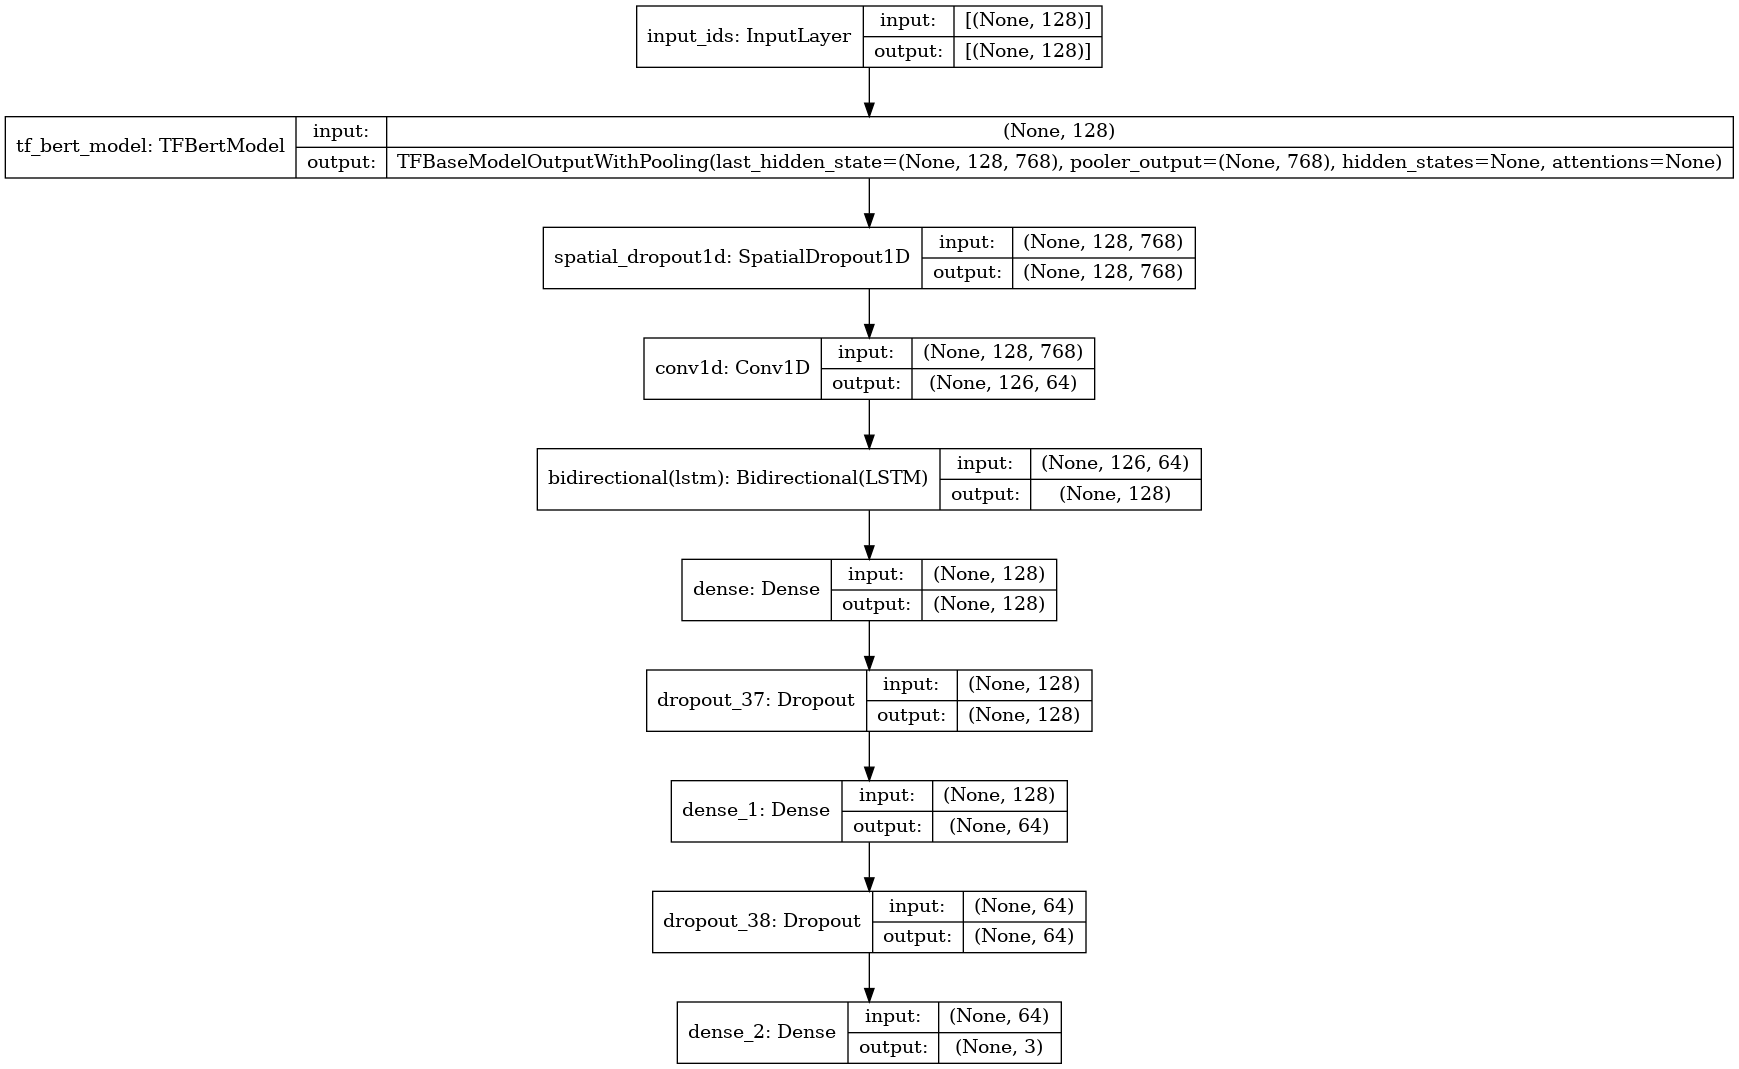

In [39]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [40]:
# Start train
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=12,
    validation_data=dev_dataset,
    verbose=1)
    #callbacks=[tf.keras.callbacks.EarlyStopping(
    #            patience=6,
    #            min_delta=0.05,
    #            baseline=0.7,
    #            mode='min',
    #            monitor='val_accuracy',
    #            restore_best_weights=True,
    #            verbose=1)
    #          ])

Epoch 1/12
215/215 [==============================] - 158s 373ms/step - loss: 1.0271 - accuracy: 0.4592 - val_loss: 0.6011 - val_accuracy: 0.7744
Epoch 2/12
215/215 [==============================] - 22s 104ms/step - loss: 0.6767 - accuracy: 0.7504 - val_loss: 0.5037 - val_accuracy: 0.8140
Epoch 3/12
215/215 [==============================] - 23s 105ms/step - loss: 0.5920 - accuracy: 0.7826 - val_loss: 0.4520 - val_accuracy: 0.8341
Epoch 4/12
215/215 [==============================] - 22s 104ms/step - loss: 0.5308 - accuracy: 0.8099 - val_loss: 0.4043 - val_accuracy: 0.8617
Epoch 5/12
215/215 [==============================] - 23s 105ms/step - loss: 0.4884 - accuracy: 0.8302 - val_loss: 0.3609 - val_accuracy: 0.8854
Epoch 6/12
215/215 [==============================] - 22s 104ms/step - loss: 0.4370 - accuracy: 0.8524 - val_loss: 0.3210 - val_accuracy: 0.8908
Epoch 7/12
215/215 [==============================] - 22s 104ms/step - loss: 0.4027 - accuracy: 0.8702 - val_loss: 0.2820 - val_a

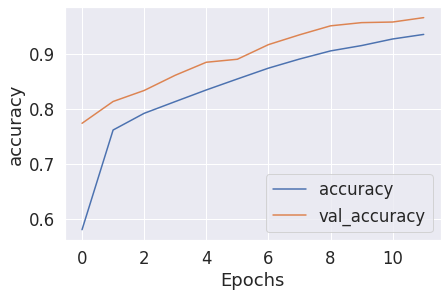

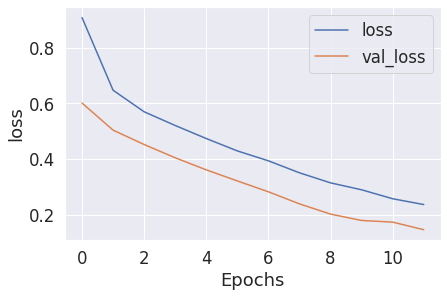

In [41]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Predict Manually Before Using Test Data

Decoder to be able to see results as labelled negative, positive or neutral

In [42]:
def decode_sentiment(score):
        if score == 0:
            return "negative"
        elif score == 1:
            return "neutral"
        else:
            return "positive"

In [43]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_encoded = bert_encode([text])
    # Predict
    score = model.predict([x_encoded])[0]
    # Decode sentiment
    label = decode_sentiment(np.argmax(score))

    return {"label": label, "score": score,
       "elapsed_time": time.time()-start_at}  

In [44]:
predict("I hate the economy")

{'label': 'negative',
 'score': array([0.99226695, 0.00606439, 0.00166867], dtype=float32),
 'elapsed_time': 9.046277523040771}

In [45]:
predict("I would prefer writing a crawler to create this dataset but i couldn't")

{'label': 'neutral',
 'score': array([0.00781879, 0.97881645, 0.01336478], dtype=float32),
 'elapsed_time': 0.38849425315856934}

In [46]:
predict("I LOVE NLP")

{'label': 'positive',
 'score': array([0.00235216, 0.00462052, 0.9930273 ], dtype=float32),
 'elapsed_time': 0.39040517807006836}

In [47]:
predict("life is really strange isn't it? just the combination of laugh and sadness")

{'label': 'neutral',
 'score': array([0.01704575, 0.95690346, 0.02605083], dtype=float32),
 'elapsed_time': 0.389385461807251}

In [48]:
predict("ESL is the world's largest esports company, leading the industry across the most popular video games.\
        We're proud they've chosen us to help them deliver their launchers to gamers all over the world. Read the full review")

{'label': 'positive',
 'score': array([0.00322378, 0.00675376, 0.99002254], dtype=float32),
 'elapsed_time': 0.3866870403289795}

In [49]:
predict("Excited to present a tutorial on 'Modular and Parameter-Efficient Fine-Tuning for NLP Models' \
        at #EMNLP2022 with @PfeiffJo & @licwu.")

{'label': 'positive',
 'score': array([0.00288185, 0.00604494, 0.9910732 ], dtype=float32),
 'elapsed_time': 0.3969578742980957}

In [50]:
predict("Had a song stuck in my head. Thirty seconds later I'm listening to it, thanks to the internet,\
        and Apple/YouTube Music. In the bad old days I'd browse record stores for hours in the hope that the title might jog my memory.\
        It really is a wonderful time to be alive!")

{'label': 'neutral',
 'score': array([0.01911314, 0.9223726 , 0.05851424], dtype=float32),
 'elapsed_time': 0.39455389976501465}

In [51]:
predict("i don't say this lightly - hemingway's life ended by suicide. His life was actually a loss")

{'label': 'negative',
 'score': array([0.9821215 , 0.01393433, 0.00394414], dtype=float32),
 'elapsed_time': 0.40785884857177734}

In [52]:
predict("these r not ur problems dear!!! these r ur x bf's commitng suicide")

{'label': 'negative',
 'score': array([0.9911284 , 0.00696441, 0.00190715], dtype=float32),
 'elapsed_time': 0.39609289169311523}

In [53]:
predict("i hve no idea about that i love the uni or not")

{'label': 'neutral',
 'score': array([0.03834428, 0.65788496, 0.30377078], dtype=float32),
 'elapsed_time': 0.39946961402893066}

In [54]:
predict("I found some old Reddit post in which one guy from english-speaking country complains that\
the names in The Witcher books are 'too difficult' and non- intuitive for english speaker.\
Man, let me introduce you to 'The books werent written only/for english speakers.'' #witcher")

{'label': 'negative',
 'score': array([0.9896205 , 0.00824646, 0.00213307], dtype=float32),
 'elapsed_time': 0.40537476539611816}

In [55]:
predict("I forgot how cringy all the Slavic names sound read it English \
YOU'RE PRONOUNCING IT ALL WRONG MY EARS ARE HURTING AND I DON'T EVEN HAVE HEARING AIDS IN")

{'label': 'negative',
 'score': array([0.99142796, 0.00667349, 0.00189854], dtype=float32),
 'elapsed_time': 0.39074015617370605}

In [56]:
predict("fun fact: ai cannot predict everything right")

{'label': 'positive',
 'score': array([0.04326839, 0.43208045, 0.5246511 ], dtype=float32),
 'elapsed_time': 0.3884127140045166}

In [57]:
predict("our brain is just a machine as well")

{'label': 'neutral',
 'score': array([0.00585391, 0.9839322 , 0.01021382], dtype=float32),
 'elapsed_time': 0.3986966609954834}

# Evaluate

In [58]:
test_encoded = bert_encode(df_test.text_clean)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_encoded)
    .batch(batch_size)
)

predicted_tweets = model.predict(test_dataset, batch_size=batch_size)
predicted_tweets_binary = tf.cast(tf.round(predicted_tweets), tf.int32).numpy().flatten()

In [59]:
y_pred = []
for i in range(predicted_tweets.shape[0]):
    y_pred.append(np.argmax(predicted_tweets[i]))

In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1001
           1       0.72      0.79      0.75      1430
           2       0.84      0.80      0.82      1103

    accuracy                           0.78      3534
   macro avg       0.79      0.77      0.78      3534
weighted avg       0.78      0.78      0.78      3534



_____
### In next step, we will use our prepared model to predict tweets on twitter using Twint.

# Fetching data from Twitter
To get started,

* Import the twint package as follows.

In [86]:
!pip install twint
import twint
import nest_asyncio
nest_asyncio.apply() 
!pip install --user --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint

  Cloning https://github.com/twintproject/twint.git (to revision origin/master) to /tmp/pip-install-i70st57p/twint_ca261953fca240d9a749c17e940bcac1
  Running command git clone -q https://github.com/twintproject/twint.git /tmp/pip-install-i70st57p/twint_ca261953fca240d9a749c17e940bcac1
  Running command git checkout -q origin/master
  Resolved https://github.com/twintproject/twint.git to commit origin/master


In [87]:
c = twint.Config()
c.Search = "GRAMMYs" #keyword for search
c.Limit = 100 #limit of the number of tweets which will be extracted
c.Store_csv = True 
c.Output = '#GRAMMYs_tweet_data.csv'
twint.run.Search(c)

1473980883686367237 2021-12-23 11:36:42 +0000 <Adi_Sterling> Checkout Tunechi’s ‘drop the world’ performance at the 2010 Grammys with Travis Barker.
1473980339450118147 2021-12-23 11:34:32 +0000 <vynguyenle1408> @Interzoo0 @crashingstyle89 @talkofthecharts yes i mean grammys
1473980033270222852 2021-12-23 11:33:19 +0000 <Interzoo0> @vynguyenle1408 @crashingstyle89 @talkofthecharts related to the Grammys?
1473979718307397635 2021-12-23 11:32:04 +0000 <iCiara> @hushmirrorball I think she will do something like this in the build up to the Grammys for Evermore. I’m afraid I do indeed need your closure, blondie. 🙏🏻
1473979352178212865 2021-12-23 11:30:37 +0000 <JideMawutor> Wizkid shot both Essence and the MIL Short Films in Ghana with Ghanaian crew.  It is not that we don't have the resources ohh. Do we know how to use it?  Essence is nominated for the Best Global Music Performance at the Grammys.  The short film is even better.
1473979044530171909 2021-12-23 11:29:24 +0000 <qorton4> @isaa

## We stored the related tweets in the .csv or .json file which is really fast and cool

So how we will read from csv/json file to use for our purpose ? 

In [88]:
crawled_data = pd.read_csv("#GRAMMYs_tweet_data.csv")
#crawled_data = pd.read_json("tweet_data.json", lines=True)
pd.options.display.max_columns=36
crawled_data.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1473980883686367237,1473980883686367237,2021-12-23 11:36:42 UTC,2021-12-23,11:36:42,0,1914067039,adi_sterling,Adnan♊️,NaN,Checkout Tunechi’s ‘drop the world’ performanc...,en,[],[],[],0,0,0,[],[],https://twitter.com/Adi_Sterling/status/147398...,False,https://twitter.com/ibrahim_ugah/status/147369...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,1473980339450118147,1473878987344592896,2021-12-23 11:34:32 UTC,2021-12-23,11:34:32,0,1435829702766186496,vynguyenle1408,Vyvy³⁰,NaN,@Interzoo0 @crashingstyle89 @talkofthecharts y...,en,[],[],[],0,0,0,[],[],https://twitter.com/vynguyenle1408/status/1473...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'Interzoo0', 'name': 'Manati ...",NaN,NaN,NaN,NaN
2,1473980033270222852,1473878987344592896,2021-12-23 11:33:19 UTC,2021-12-23,11:33:19,0,1389861851538853892,interzoo0,Manati l Stream Oh My God by Adele,NaN,@vynguyenle1408 @crashingstyle89 @talkofthecha...,en,[],[],[],1,0,0,[],[],https://twitter.com/Interzoo0/status/147398003...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'vynguyenle1408', 'name': 'Vy...",NaN,NaN,NaN,NaN
3,1473979718307397635,1473853647624749067,2021-12-23 11:32:04 UTC,2021-12-23,11:32:04,0,20199704,iciara,Ciara,NaN,@hushmirrorball I think she will do something ...,en,[],[],[],0,0,0,[],[],https://twitter.com/iCiara/status/147397971830...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'hushmirrorball', 'name': ""eM...",NaN,NaN,NaN,NaN
4,1473979352178212865,1473979352178212865,2021-12-23 11:30:37 UTC,2021-12-23,11:30:37,0,2214436452,jidemawutor,Dzide,NaN,Wizkid shot both Essence and the MIL Short Fil...,en,[],[],[],0,0,0,[],[],https://twitter.com/JideMawutor/status/1473979...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


_____
As you can see above we have lots of features which extracted by twint. However, we only need the "tweet" feature which includes the text data of tweets for our purpose.

In [93]:
# prediction of the first 15 extracted tweets
for i in range(15):
    print(crawled_data["tweet"][i])
    print(predict(crawled_data["tweet"][i]))
    print("\n")

Checkout Tunechi’s ‘drop the world’ performance at the 2010 Grammys with Travis Barker.
{'label': 'neutral', 'score': array([0.01953116, 0.8722475 , 0.10822131], dtype=float32), 'elapsed_time': 0.39107751846313477}


@Interzoo0 @crashingstyle89 @talkofthecharts yes i mean grammys
{'label': 'neutral', 'score': array([0.01343942, 0.95331293, 0.03324767], dtype=float32), 'elapsed_time': 0.390610933303833}


@vynguyenle1408 @crashingstyle89 @talkofthecharts related to the Grammys?
{'label': 'neutral', 'score': array([0.00696629, 0.97773516, 0.01529855], dtype=float32), 'elapsed_time': 0.3901488780975342}


@hushmirrorball I think she will do something like this in the build up to the Grammys for Evermore. I’m afraid I do indeed need your closure, blondie. 🙏🏻
{'label': 'neutral', 'score': array([0.01787372, 0.94304776, 0.03907843], dtype=float32), 'elapsed_time': 0.4018416404724121}


Wizkid shot both Essence and the MIL Short Films in Ghana with Ghanaian crew.  It is not that we don't have

### If you want to know more about twint, you can checkout this Github link:
https://github.com/twintproject/twint